In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import MDS
from sklearn.metrics import roc_curve, auc

In [5]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# Preparing data

In [54]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [55]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training the encoder

In [20]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class CNN(nn.Module):
    def __init__(self, feature_dim=24):
        super(CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, feature_dim),
            nn.ReLU()
        )
        
        self.classifier = nn.Linear(feature_dim, 10)
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output
    
    def extract_features(self, x):
        return self.encoder(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [22]:
model

CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=24, bias=True)
    (8): ReLU()
  )
  (classifier): Linear(in_features=24, out_features=10, bias=True)
)

In [23]:
num_epochs = 5
print("Training the model...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {100 * correct / total:.2f}%')

print("Training completed!")

Training the model...
Epoch [1/5], Step [100/938], Loss: 0.3848
Epoch [1/5], Step [200/938], Loss: 0.1825
Epoch [1/5], Step [300/938], Loss: 0.1052
Epoch [1/5], Step [400/938], Loss: 0.1078
Epoch [1/5], Step [500/938], Loss: 0.1023
Epoch [1/5], Step [600/938], Loss: 0.1632
Epoch [1/5], Step [700/938], Loss: 0.1351
Epoch [1/5], Step [800/938], Loss: 0.0507
Epoch [1/5], Step [900/938], Loss: 0.0507
Epoch [1/5], Test Accuracy: 97.97%
Epoch [2/5], Step [100/938], Loss: 0.0684
Epoch [2/5], Step [200/938], Loss: 0.1663
Epoch [2/5], Step [300/938], Loss: 0.0421
Epoch [2/5], Step [400/938], Loss: 0.0204
Epoch [2/5], Step [500/938], Loss: 0.0404
Epoch [2/5], Step [600/938], Loss: 0.0630
Epoch [2/5], Step [700/938], Loss: 0.0230
Epoch [2/5], Step [800/938], Loss: 0.0068
Epoch [2/5], Step [900/938], Loss: 0.1996
Epoch [2/5], Test Accuracy: 98.55%
Epoch [3/5], Step [100/938], Loss: 0.0554
Epoch [3/5], Step [200/938], Loss: 0.0849
Epoch [3/5], Step [300/938], Loss: 0.0913
Epoch [3/5], Step [400/938

Extracting features for visualization...


(1000, 24)
Applying Multidimensional Scaling...


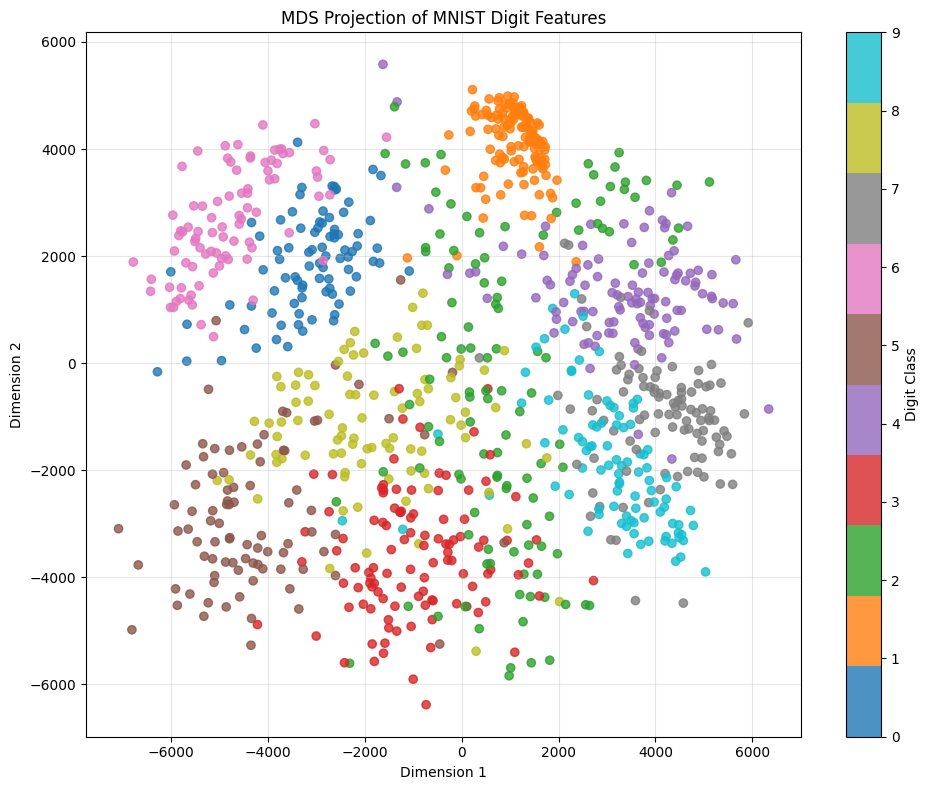

In [ ]:
subset_size = 1000
images, labels = test_dataset.data[:subset_size].unsqueeze(1).float(), test_dataset.targets[:subset_size]
images = images.to(device)

model.eval()
with torch.no_grad():
    features = model.extract_features(images).cpu().numpy()

mds = MDS(n_components=2, random_state=42, n_init=1)
features_2d = mds.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('MDS Projection of MNIST Digit Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('mnist_mds_visualization.png')
plt.show()

# Dataset corruption

In [124]:
from copy import deepcopy

def corrupt_labels(dataset, noise_rate=0.2):
    """
    Corrupt a fraction of labels in the dataset
    """
    dataset = deepcopy(dataset)
    corrupted_targets = dataset.targets.clone()
    
    num_samples = len(dataset)
    num_classes = 10
    
    num_to_corrupt = int(noise_rate * num_samples)
    corrupt_indices = torch.randperm(num_samples)[:num_to_corrupt]
    
    corrupted_idx = []
    original_labels = []
    new_labels = []
    
    for idx in corrupt_indices:
        original_label = corrupted_targets[idx].item()
        original_labels.append(original_label)
        
        possible_labels = list(range(num_classes))
        possible_labels.remove(original_label)
        new_label = np.random.choice(possible_labels)
        
        corrupted_targets[idx] = new_label
        
        corrupted_idx.append(idx.item())
        new_labels.append(new_label)
    
    dataset.targets = corrupted_targets
    
    print(f"Created dataset with {noise_rate*100:.1f}% noisy labels")
    print(f"Number of corrupted labels: {len(corrupted_idx)}")
    
    return dataset, {
        'corrupted_indices': corrupted_idx,
        'original_labels': original_labels,
        'new_labels': new_labels
    }
    
corrupted_train_dataset, corruption_info = corrupt_labels(train_dataset, noise_rate=0.2)
is_corrupted = np.zeros(len(corrupted_train_dataset), dtype=bool)
is_corrupted[corruption_info['corrupted_indices']] = True

corrupted_train_loader = DataLoader(corrupted_train_dataset, batch_size=batch_size, shuffle=False)

Created dataset with 20.0% noisy labels
Number of corrupted labels: 12000


# Training baseline model on corrupted data

Epoch 1: Train Loss: 1.1460, Test Acc: 97.85%
Epoch 2: Train Loss: 1.0500, Test Acc: 98.35%
Epoch 3: Train Loss: 1.0274, Test Acc: 98.44%
Epoch 4: Train Loss: 1.0127, Test Acc: 98.35%
Epoch 5: Train Loss: 1.0010, Test Acc: 98.43%


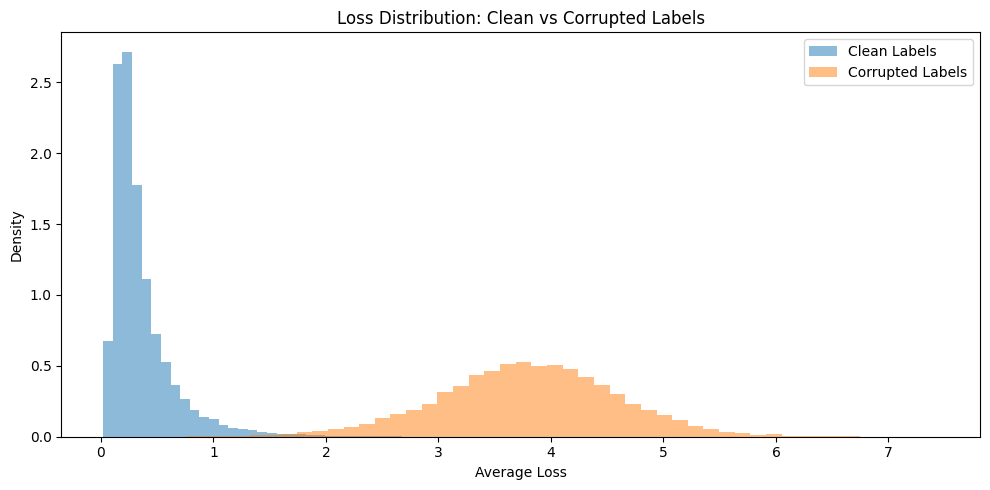

In [126]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc(x)
        return x
    
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_history = torch.zeros(len(corrupted_train_dataset), 5)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    batch_idx = 0
    
    for images, labels in corrupted_train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss_per_sample = criterion(outputs, labels)
        loss = loss_per_sample.mean()
        
        loss.backward()
        optimizer.step()
        
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(train_dataset))
        loss_history[start_idx:end_idx, epoch] = loss_per_sample.detach().cpu()
        
        batch_idx += 1
        running_loss += loss.item()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, Test Acc: {100*correct/total:.2f}%')

avg_loss = loss_history.mean(dim=1)

plt.figure(figsize=(10, 5))

plt.hist(avg_loss[~is_corrupted].numpy(), bins=50, alpha=0.5, label='Clean Labels', density=True)
plt.hist(avg_loss[is_corrupted].numpy(), bins=50, alpha=0.5, label='Corrupted Labels', density=True)
plt.xlabel('Average Loss')
plt.ylabel('Density')
plt.title('Loss Distribution: Clean vs Corrupted Labels')
plt.legend()

plt.tight_layout()
plt.savefig('loss_analysis.png')
plt.show()